In [1]:
import msprime as msp
import demes
import demesdraw

demo = msp.Demography()
demo.add_population(initial_size = 5000, name = "anc")
demo.add_population(initial_size = 5000, name = "P0")
demo.add_population(initial_size = 5000, name = "P1")
demo.set_symmetric_migration_rate(populations=("P0", "P1"), rate=0.001)
tmp = [f"P{i}" for i in range(2)]
demo.add_population_split(time = 1000, derived=tmp, ancestral="anc")
g = demo.to_demes()
sample_size = 10
samples = {f"P{i}": sample_size for i in range(2)}
anc = msp.sim_ancestry(samples=samples, demography=demo, recombination_rate=1e-8, sequence_length=1e7, random_seed = 12)
ts = msp.sim_mutations(anc, rate=1e-8, random_seed = 12)

In [2]:
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import random
key = jr.PRNGKey(0)

In [3]:
from demesinfer.coal_rate import PiecewiseConstant
import jax

key, subkey = jr.split(key)

def sample_tmrca_spanss(ts, subkey=jax.random.PRNGKey(1), num_pop=2):
    samples = jax.random.choice(subkey, ts.num_samples, shape=(2,), replace=False)
    sample1, sample2 = samples[0], samples[1]

    pop_cfg = {ts.population(ts.node(n).population).metadata["name"] for n in ts.samples()}
    pop_cfg = {pop_name: 0 for pop_name in pop_cfg}
    pop_cfg[ts.population(ts.node(sample1.item(0)).population).metadata["name"]] += 1
    pop_cfg[ts.population(ts.node(sample2.item(0)).population).metadata["name"]] += 1

    pop1 = ts.node(sample1.item(0)).population - 1
    pop2 = ts.node(sample2.item(0)).population - 1
    sample_config = (pop1, pop2)

    # Precompute all TMRCAs and spans into arrays
    tmrcas = []
    spans = []
    for tree in ts.trees():
        spans.append(tree.interval.right - tree.interval.left)
        tmrcas.append(tree.tmrca(sample1, sample2))
    
    # Convert to JAX arrays
    tmrcas = jnp.array(tmrcas)  # Shape: (num_trees,)
    spans = jnp.array(spans)    # Shape: (num_trees,)
    tmrcas_spans = jnp.stack([tmrcas, spans], axis=1)  # Shape: (num_trees, 2)

    # Merge consecutive spans with same TMRCA
    def merge_spans(carry, x):
        current_tmrca, current_span, idx, output = carry
        tmrca, span = x
        
        # Update each component individually
        new_tmrca = jnp.where(tmrca == current_tmrca, current_tmrca, tmrca)
        new_span = jnp.where(tmrca == current_tmrca, current_span + span, span)
        new_idx = jnp.where(tmrca == current_tmrca, idx, idx + 1)
        new_output = jnp.where(
            tmrca == current_tmrca, 
            output, 
            output.at[idx].set(jnp.array([current_tmrca, current_span]))
        )
        
        return (new_tmrca, new_span, new_idx, new_output), None

    init_carry = (tmrcas_spans[0, 0], 0.0, 0, jnp.full((ts.num_trees, 2), jnp.array([1.0, 0.0])))
    final_carry, _ = jax.lax.scan(merge_spans, init_carry, tmrcas_spans)
    final_tmrca, final_span, _, final_output = final_carry
    final_output = final_output.at[-1].set(jnp.array([final_tmrca, final_span]))
    is_ones = jnp.all(final_output == jnp.array([1.0, 0.0]), axis=1)
    reordered_arr = jnp.concatenate([final_output[~is_ones], final_output[is_ones]])

    return reordered_arr, sample_config, pop_cfg, final_output[~is_ones]

all_tmrca_spans = []
all_sample_configs = []
cfg_list = []
all_tmrca_spans_no_pad = []
for i in range(20):
    key, subkey = jr.split(key)
    tmrca_spans, sample_config, pop_cfg, tmrca_spans_no_pad = sample_tmrca_spanss(ts, subkey)
    all_tmrca_spans.append(tmrca_spans)
    all_sample_configs.append(sample_config)
    cfg_list.append(pop_cfg)
    all_tmrca_spans_no_pad.append(tmrca_spans_no_pad)

all_sample_configs = jnp.array(all_sample_configs)
all_tmrca_spans = jnp.array(all_tmrca_spans)

In [4]:
from typing import Mapping, Sequence, Tuple, List, Dict, Any, Optional, Set

Path  = Tuple[Any, ...]
Var   = Path | Set[Path]             
Params = Mapping[Var, float]

def _dict_to_vec(d: Params, keys: Sequence[Var]) -> jnp.ndarray:
    return jnp.asarray([d[k] for k in keys], dtype=jnp.float64)

def _vec_to_dict_jax(v: jnp.ndarray, keys: Sequence[Var]) -> Dict[Var, jnp.ndarray]:
    return {k: v[i] for i, k in enumerate(keys)}

def _vec_to_dict(v: jnp.ndarray, keys: Sequence[Var]) -> Dict[Var, float]:
    return {k: float(v[i]) for i, k in enumerate(keys)}

paths = {
    frozenset({
        ('demes', 1, 'epochs', 0, 'end_size'),
        ('demes', 1, 'epochs', 0, 'start_size'),
    }): 4000.,
}
# paths = {frozenset({('demes', 0, 'epochs', 0, 'end_time'), ('demes', 1, 'start_time'), ('demes', 2, 'start_time'), ('migrations', 0, 'start_time'), ('migrations', 1, 'start_time')}) : 9000.}
Path = Tuple[Any, ...] # A path is a tuple of arbitrary elements. This Path variable becomes a type alias for a tuple that can contain any element type
Params = Mapping[Path, float] # A mapping from paths to float values. This Params variable becomes a type alias for dictionaries where the key are the Path tuples and the values are float
path_order: List[Path] = list(paths) # this converts the paths set into a list, note that the ordering is randomized because a set is unordered and when you convert to list the order changes
x0 = _dict_to_vec(paths, path_order)
print(x0)
from demesinfer.constr import EventTree, constraints_for
et = EventTree(g)
et.variables

2025-08-05 07:32:15.937 | DEBUG    | demesinfer.event_tree:_add_node:482 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-05 07:32:15.938 | DEBUG    | demesinfer.event_tree:_add_node:482 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-05 07:32:15.938 | DEBUG    | demesinfer.event_tree:_add_node:482 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-05 07:32:15.942 | DEBUG    | demesinfer.event_tree:_add_node:482 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('migrations', 0, 'end_time')}
2025-08-05 07:32:15.944 | DEBUG    | demesinfer.event_tree:_add_edge:463 - adding edge 2 -> 3
2025-08-05 07:32:15.944 | DEBUG    | demesinfer.event_tree:_add_edge:463 - adding edg

[4000.]


[frozenset({('demes', 0, 'epochs', 0, 'end_size'),
            ('demes', 0, 'epochs', 0, 'start_size')}),
 frozenset({('demes', 1, 'epochs', 0, 'end_size'),
            ('demes', 1, 'epochs', 0, 'start_size')}),
 frozenset({('demes', 2, 'epochs', 0, 'end_size'),
            ('demes', 2, 'epochs', 0, 'start_size')}),
 ('demes', 1, 'proportions', 0),
 ('demes', 2, 'proportions', 0),
 ('migrations', 0, 'rate'),
 ('migrations', 1, 'rate'),
 frozenset({('demes', 0, 'epochs', 0, 'end_time'),
            ('demes', 1, 'start_time'),
            ('demes', 2, 'start_time'),
            ('migrations', 0, 'start_time'),
            ('migrations', 1, 'start_time')}),
 frozenset({('demes', 1, 'epochs', 0, 'end_time'),
            ('demes', 2, 'epochs', 0, 'end_time'),
            ('migrations', 0, 'end_time'),
            ('migrations', 1, 'end_time')})]

In [5]:
cons = constraints_for(et, *path_order)
print(cons)
from scipy.optimize import minimize, LinearConstraint
linear_constraints: list[LinearConstraint] = []

Aeq, beq = cons["eq"]
if Aeq.size:
    linear_constraints.append(LinearConstraint(Aeq, beq, beq))

G, h = cons["ineq"]
if G.size:
    lower = -jnp.inf * jnp.ones_like(h)
    linear_constraints.append(LinearConstraint(G, lower, h))

{'eq': (array([], shape=(0, 1), dtype=float64), array([], dtype=float64)), 'ineq': (array([[-1.]]), array([0.]))}


In [6]:
deme_names = cfg_list[0].keys()
D = len(deme_names)
cfg_mat = jnp.zeros((20, D), dtype=jnp.int32)
for i, cfg in enumerate(cfg_list):
    for j, n in enumerate(deme_names):
        cfg_mat = cfg_mat.at[i, j].set(cfg.get(n, 0))


cfg_keys, cfg_idx = jnp.unique(cfg_mat, axis=0, return_inverse=True)

first_columns = all_tmrca_spans[:, :, 0]
# Compute global max (single float value)
global_max = jnp.max(first_columns)

t_breaks = jnp.linspace(1e-8, global_max * 2, 3000)
rho = 1e-8
    
from demesinfer.iicr import IICRCurve
from jax import jit 
iicr = IICRCurve(g, 2)
iicr_call = jax.jit(iicr.__call__)


2025-08-05 07:32:20.213 | DEBUG    | demesinfer.event_tree:_add_node:482 - creating node 0 with attributes {'event': PopulationStart(), 'block': frozenset({'anc'}), 't': ('demes', 0, 'epochs', 0, 'end_time')}
2025-08-05 07:32:20.213 | DEBUG    | demesinfer.event_tree:_add_node:482 - creating node 1 with attributes {'event': PopulationStart(), 'block': frozenset({'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-05 07:32:20.214 | DEBUG    | demesinfer.event_tree:_add_node:482 - creating node 2 with attributes {'event': PopulationStart(), 'block': frozenset({'P1'}), 't': ('demes', 2, 'epochs', 0, 'end_time')}
2025-08-05 07:32:20.214 | DEBUG    | demesinfer.event_tree:_add_node:482 - creating node 3 with attributes {'event': Merge(), 'block': frozenset({'P1', 'P0'}), 't': ('demes', 1, 'epochs', 0, 'end_time')}
2025-08-05 07:32:20.214 | DEBUG    | demesinfer.event_tree:_add_edge:463 - adding edge 2 -> 3
2025-08-05 07:32:20.214 | DEBUG    | demesinfer.event_tree:_add_edge:463 - ad

In [7]:
from demesinfer.loglik import loglik
from jax import vmap

# def compute_loglik(sample_config, data, deme_names, t_breaks, rho, path_order):
def compute_loglik(vec, sample_config, data):
    # Convert sample_config (array) to dictionary of population sizes
    ns = {name: sample_config[i] for i, name in enumerate(deme_names)}
    
    # Initialize params (assuming fixed for all samples)
    params = _vec_to_dict_jax(vec, path_order)
    
    # Compute IICR and log-likelihood
    c = iicr_call(params=params, t=t_breaks, num_samples=ns)["c"]
    eta = PiecewiseConstant(c=c, t=t_breaks)
    return loglik(eta, rho, data)

# vec = [1000.]
# batched_loglik = vmap(
#     compute_loglik,
#     in_axes=(None, 0, 0))(vec, cfg_mat, all_tmrca_spans)

# for i in range(20):
#     sample_config = cfg_mat[i]
#     data = all_tmrca_spans[i]
#     ns = {name: sample_config[i] for i, name in enumerate(deme_names)}
#     params = _vec_to_dict_jax([1000.], path_order)
#     c = iicr_call(params=params, t=t_breaks, num_samples=ns)["c"]
#     eta = PiecewiseConstant(c=c, t=t_breaks)
#     loglik(eta, rho, data)



In [8]:
#@jax.jit
@jax.value_and_grad
def neg_loglik(vec):
    vec = vec * 5000.
    batched_loglik = vmap(
    compute_loglik,
    in_axes=(None, 0, 0))(vec, cfg_mat, all_tmrca_spans)
    
    likelihood = jnp.sum(batched_loglik)

    return -likelihood / 20

res = minimize(
    fun=lambda x: float(neg_loglik(x)[0]),
    x0=jnp.asarray([4000. / 5000.]),
    jac=lambda x: jnp.asarray(neg_loglik(x)[1], dtype=float),
    method="trust-constr",
    bounds = [(3500. / 5000., 7000. / 5000.)],
    constraints=linear_constraints,
)

result = _vec_to_dict(jnp.asarray(res.x) * 5000., path_order)

ERROR:2025-08-05 07:34:00,097:jax._src.callback:95: jax.pure_callback failed
Traceback (most recent call last):
  File "/Users/jkliang/opt/demesinfer/lib/python3.12/site-packages/jax/_src/callback.py", line 93, in pure_callback_impl
    return tree_util.tree_map(np.asarray, callback(*args))
                                          ^^^^^^^^^^^^^^^
  File "/Users/jkliang/opt/demesinfer/lib/python3.12/site-packages/jax/_src/callback.py", line 71, in __call__
    return tree_util.tree_leaves(self.callback_func(*args, **kwargs))
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jkliang/opt/demesinfer/lib/python3.12/site-packages/equinox/_errors.py", line 89, in raises
    raise _EquinoxRuntimeError(
equinox._errors._EquinoxRuntimeError: A linear solver received non-finite (NaN or inf) input and cannot determine a 
solution. 

This means that you have a bug upstream of Lineax and should check the inputs to 
`lineax.linear_solve` for non-finite values.


---

XlaRuntimeError: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "/Users/jkliang/opt/demesinfer/lib/python3.12/site-packages/jax/_src/callback.py", line 782, in _wrapped_callback
  File "/Users/jkliang/opt/demesinfer/lib/python3.12/site-packages/jax/_src/callback.py", line 222, in _callback
  File "/Users/jkliang/opt/demesinfer/lib/python3.12/site-packages/jax/_src/callback.py", line 96, in pure_callback_impl
  File "/Users/jkliang/opt/demesinfer/lib/python3.12/site-packages/jax/_src/callback.py", line 71, in __call__
  File "/Users/jkliang/opt/demesinfer/lib/python3.12/site-packages/equinox/_errors.py", line 89, in raises
_EquinoxRuntimeError: A linear solver received non-finite (NaN or inf) input and cannot determine a 
solution. 

This means that you have a bug upstream of Lineax and should check the inputs to 
`lineax.linear_solve` for non-finite values.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` (perhaps you are using `jax.jit` instead?) and so further information about the error cannot be displayed. (Probably you are seeing a very large but uninformative error message right now.) Please wrap your program with `equinox.filter_jit`.
--------------------


## Ignore everything below:
plotting log likelihood to make sure it actually is smooth and peaks somewhere

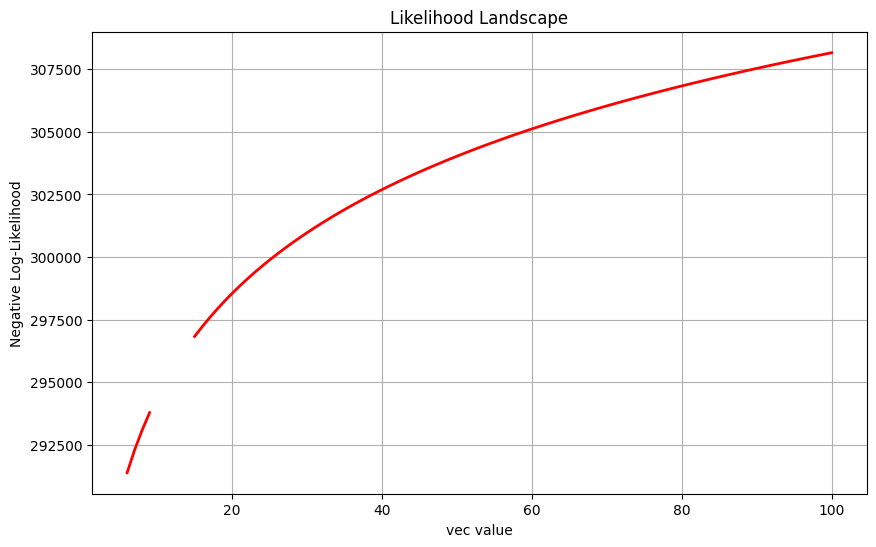

In [11]:
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt

# 1. Generate test values for vec
vec_values = jnp.linspace(1., 100., 100) 

# 2. Vectorize neg_loglik over vec_values while preserving internal batching
def evaluate_at_vec(vec):
    vec_array = jnp.atleast_1d(vec)
    # Inner vmap: Batched over cfg_mat and all_tmrca_spans (shape preservation)
    batched_loglik = vmap(compute_loglik, in_axes=(None, 0, 0))(vec_array, cfg_mat, all_tmrca_spans)
    return -jnp.sum(batched_loglik) / 20  # Same as original neg_loglik

# Outer vmap: Parallelize across vec_values
batched_neg_loglik = vmap(evaluate_at_vec)  # in_axes=0 is default

# 3. Compute all values (runs on GPU/TPU if available)
results = batched_neg_loglik(vec_values) 

# 4. Plot
plt.figure(figsize=(10, 6))
plt.plot(vec_values, results, 'r-', linewidth=2)
plt.xlabel("vec value")
plt.ylabel("Negative Log-Likelihood")
plt.title("Likelihood Landscape")
plt.grid(True)
plt.show()

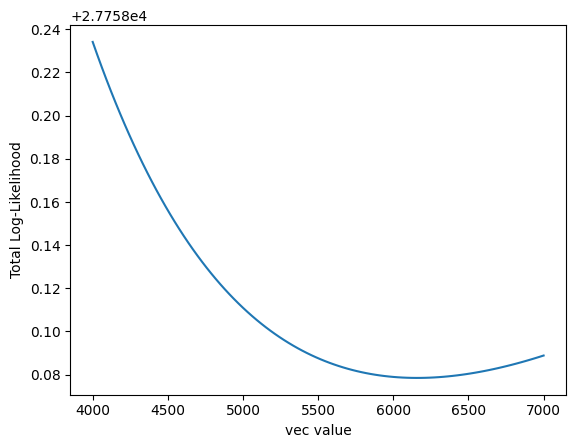

In [12]:
# vec_values = jnp.linspace(500., 1500., 100)
vec_values = jnp.linspace(4000, 7000, 100) 

def compute_loglik(vec, sample_config, data):
    vec = jnp.array([vec])
    # Convert sample_config (array) to dictionary of population sizes
    ns = {name: sample_config[i] for i, name in enumerate(deme_names)}
    
    # Initialize params (assuming fixed for all samples)
    params = _vec_to_dict_jax(vec, path_order)
    
    # Compute IICR and log-likelihood
    c = iicr_call(params=params, t=t_breaks, num_samples=ns)["c"]
    eta = PiecewiseConstant(c=c, t=t_breaks)
    return loglik(eta, rho, data)

final_results = []
for sample_config, data in zip(cfg_mat, all_tmrca_spans_no_pad):
    batched_results = vmap(compute_loglik, in_axes=(0, None, None))(
            vec_values,  # Ensure vec is array-shaped
            sample_config,          # Shape (N, D)
            data  # Shape (N, ...)
        )

    final_results.append(-batched_results)

# 1. Stack arrays vertically
stacked_data = jnp.vstack(final_results)  # Combines all arrays into 2D matrix

# 2. Compute mean across columns (axis=0)
column_means = jnp.mean(stacked_data, axis=0)
column_means


# 4. Plotting
import matplotlib.pyplot as plt
plt.plot(vec_values, column_means)
plt.xlabel("vec value")
plt.ylabel("Total Log-Likelihood")
plt.show()

## Ignore everything below

In [24]:
max_values = jnp.max(all_tmrca_spans[:, :, 0], axis=1)  # Max along first column for each sample
max_values

Array([188887.78715386, 197158.06409269, 204024.80496577, 197158.06409269,
       197158.06409269, 188887.78715386, 204024.80496577, 204024.80496577,
       197158.06409269, 188887.78715386, 188887.78715386, 197158.06409269,
       197158.06409269, 204024.80496577, 204024.80496577, 204024.80496577,
       188887.78715386, 204024.80496577, 179274.06855031, 197158.06409269],      dtype=float64)

In [27]:
first_columns = all_tmrca_spans[:, :, 0]

# Compute global max (single float value)
global_max = jnp.max(first_columns)
global_max

Array(204024.80496577, dtype=float64)

In [5]:
from demesinfer.coal_rate import PiecewiseConstant
import jax

key, subkey = jr.split(key)

def sample_tmrca_spanss(ts, subkey=jax.random.PRNGKey(1), num_pop=2):
    samples = jax.random.choice(subkey, ts.num_samples, shape=(2,), replace=False)
    sample1, sample2 = samples[0], samples[1]

    pop_cfg = {ts.population(ts.node(n).population).metadata["name"] for n in ts.samples()}
    pop_cfg = {pop_name: 0 for pop_name in pop_cfg}
    pop_cfg[ts.population(ts.node(sample1.item(0)).population).metadata["name"]] += 1
    pop_cfg[ts.population(ts.node(sample2.item(0)).population).metadata["name"]] += 1

    pop1 = ts.node(sample1.item(0)).population - 1
    pop2 = ts.node(sample2.item(0)).population - 1
    sample_config = (pop1, pop2)

    # Precompute all TMRCAs and spans into arrays
    tmrcas = []
    spans = []
    for tree in ts.trees():
        spans.append(tree.interval.right - tree.interval.left)
        tmrcas.append(tree.tmrca(sample1, sample2))
    
    # Convert to JAX arrays
    tmrcas = jnp.array(tmrcas)  # Shape: (num_trees,)
    spans = jnp.array(spans)    # Shape: (num_trees,)
    tmrcas_spans = jnp.stack([tmrcas, spans], axis=1)  # Shape: (num_trees, 2)

    # Merge consecutive spans with same TMRCA
    def merge_spans(carry, x):
        current_tmrca, current_span, idx, output = carry
        tmrca, span = x
        
        # Update each component individually
        new_tmrca = jnp.where(tmrca == current_tmrca, current_tmrca, tmrca)
        new_span = jnp.where(tmrca == current_tmrca, current_span + span, span)
        new_idx = jnp.where(tmrca == current_tmrca, idx, idx + 1)
        new_output = jnp.where(
            tmrca == current_tmrca, 
            output, 
            output.at[idx].set(jnp.array([current_tmrca, current_span]))
        )
        
        return (new_tmrca, new_span, new_idx, new_output), None

    init_carry = (tmrcas_spans[0, 0], 0.0, 0, jnp.full((ts.num_trees, 2), jnp.array([1.0, 0.0])))
    final_carry, _ = jax.lax.scan(merge_spans, init_carry, tmrcas_spans)
    final_tmrca, final_span, _, final_output = final_carry
    final_output = final_output.at[-1].set(jnp.array([final_tmrca, final_span]))
    is_ones = jnp.all(final_output == jnp.array([1.0, 0.0]), axis=1)
    reordered_arr = jnp.concatenate([final_output[~is_ones], final_output[is_ones]])
    print(final_output[~is_ones])
    print(reordered_arr)

    return reordered_arr, sample_config, pop_cfg

all_tmrca_spans = []
all_sample_configs = []
cfg_list = []
for i in range(5):
    key, subkey = jr.split(key)
    tmrca_spans, sample_config, pop_cfg = sample_tmrca_spanss(ts, subkey)
    all_tmrca_spans.append(tmrca_spans)
    all_sample_configs.append(sample_config)
    cfg_list.append(pop_cfg)

all_sample_configs = jnp.array(all_sample_configs)
all_tmrca_spans = jnp.array(all_tmrca_spans)

[[17177.83935773  1737.        ]
 [16218.11851274  5265.        ]
 [17177.83935773 17711.        ]
 ...
 [ 3909.25706641  8932.        ]
 [ 4033.20910985 35330.        ]
 [ 1131.90856773 30686.        ]]
[[1.71778394e+04 1.73700000e+03]
 [1.62181185e+04 5.26500000e+03]
 [1.71778394e+04 1.77110000e+04]
 ...
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]]
[[13552.99044357  1737.        ]
 [17177.83935773  5265.        ]
 [ 3110.25873774 21731.        ]
 ...
 [ 6806.87558264  8382.        ]
 [ 1478.24210955 51198.        ]
 [ 4033.20910985 30686.        ]]
[[1.35529904e+04 1.73700000e+03]
 [1.71778394e+04 5.26500000e+03]
 [3.11025874e+03 2.17310000e+04]
 ...
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00]]
[[17177.83935773 24713.        ]
 [34742.13119085  9992.        ]
 [ 3696.46290766   128.        ]
 ...
 [12338.40830418   127.        ]
 [10835.88234677  9507.        ]
 [10857.670061